# Week4授業課題 信用情報の学習
Kaggleの**Home Credit Default Risk**コンペティションの学習および推定を行います。

## 【問題1】コンペティション内容の確認
コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。<br>
<br>
- 何を学習し、何を予測するのか
- どのようなファイルを作りKaggleに提出するか
- 提出されたものはどういった指標値で評価されるのか

>Home Creditは借入を希望する顧客のデータ収集・分析を行い、返済能力の可否を予測する企業である<br>
><br>
>各サンプルのSK_ID_CURRおよび推測値（0と1の間）の２列からなるCSVファイルを提出。<br>
><br>
>このコンペの指標値はROC AUCである。

#### ベースラインモデルの作成
まずは単純な方法による**ベースラインモデル**を作成します。精度の基準となるモデルです。<br>
<br>
精度を高くする必要はありません。エラーなく実行でき、Kaggle側に推定値を提出できることを目指します。

## 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。<br>
<br>
検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

In [239]:
# メモリ使用量の節約関数
# ソースコードはkernelより取得
import numpy as np
import pandas as pd

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [520]:
#データの読み込み
print("train")
train_raw = import_data('/Users/tamiyagt/Documents/Machine Learning/02_Kaggle/home credit/application_train.csv')
print("test")
test_raw = import_data('/Users/tamiyagt/Documents/Machine Learning/02_Kaggle/home credit/application_test.csv')

np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 300)

train
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
test
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%


>データ全体に対して前処理を行うため、trainとtestを結合する。

In [521]:
# あとでデータ分割するために要素数を把握
ntrain = train_raw.shape[0]
ntest = test_raw.shape[0]

# 目的変数をyに格納
target = train_raw['TARGET']
# SK_ID_CURRをX_idに格納
sk_id = test_raw['SK_ID_CURR']

# trainとtestを結合
all_data = pd.concat([train_raw, test_raw]).reset_index(drop=True)
all_data.drop(['SK_ID_CURR', 'TARGET'], axis=1, inplace=True)

In [242]:
# 欠損率の確認
def get_miss(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'}
    )

    # 表を欠損率順に並べ替え、欠損値０のサンプルは除外
    mis_val_table_sort = mis_val_table[
        mis_val_table.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    
    return mis_val_table_sort

miss_data = get_miss(all_data)

print("欠損値を含む列数：{}".format(miss_data.shape[0]))
print("-----------------")
print(miss_data)

欠損値を含む列数：67
-----------------
                              Missing Values  % of Total Values
COMMONAREA_MEDI                       248360               69.7
COMMONAREA_AVG                        248360               69.7
COMMONAREA_MODE                       248360               69.7
NONLIVINGAPARTMENTS_MEDI              246861               69.3
NONLIVINGAPARTMENTS_MODE              246861               69.3
NONLIVINGAPARTMENTS_AVG               246861               69.3
FONDKAPREMONT_MODE                    243092               68.2
LIVINGAPARTMENTS_MODE                 242979               68.2
LIVINGAPARTMENTS_MEDI                 242979               68.2
LIVINGAPARTMENTS_AVG                  242979               68.2
FLOORSMIN_MODE                        241108               67.7
FLOORSMIN_MEDI                        241108               67.7
FLOORSMIN_AVG                         241108               67.7
YEARS_BUILD_MODE                      236306               66.3
YEARS_BUIL

>EXT_SOURCE_X以外の欠損値が全体の10%以上含む列を削除する。EXT_SOURCEや、欠損値10%以下の列は削除されないよう、事前に補完する。数値データは中央値、カテゴリーデータは最頻値で補完を行う。

In [596]:
# 補完する変数を特定
features = ['EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3','NAME_TYPE_SUITE',
            'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE',
            'OBS_30_CNT_SOCIAL_CIRCLE','AMT_GOODS_PRICE','AMT_ANNUITY','CNT_FAM_MEMBERS',
            'DAYS_LAST_PHONE_CHANGE']

# カテゴリー変数を特定
categorical = all_data[features].select_dtypes(exclude='number')
# 数値変数を特定
numerical = all_data[features].select_dtypes(include='number')

# カテゴリー変数を最頻値で補完
for f in categorical:
    all_data[f].fillna(all_data[f].mode()[0], inplace=True)

# # 数値変数を中央値で補完
for f in numerical:
    all_data[f].fillna(all_data[f].median(), inplace=True)    

    
# 欠損値10%以上の列を削除
all_data_drop = all_data.dropna(axis=1, thresh=350000)

# データを確認
miss_data = get_miss(all_data_drop)

print("欠損値を含む列数：{}".format(miss_data.shape[0]))
print("-----------------")
print(miss_data)

欠損値を含む列数：0
-----------------
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


In [523]:
# LabelEncodingを行う

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in all_data_drop:
    if all_data_drop[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(all_data_drop[col].unique())) <= 2:
            # Fit the data
            le.fit(all_data_drop[col])
            # Transform both all_data
            all_data_drop[col] = le.transform(all_data_drop[col])
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('{} columns were label encoded.'.format(le_count))

0 columns were label encoded.


In [524]:
# One-Hot Encodingを行う
# ソースコードはKaggleのkernelから取得

# one-hot encoding of categorical variables
all_data_lab = pd.get_dummies(all_data_drop)

print('Data shape: ', all_data_lab.shape)

Data shape:  (356255, 160)


In [525]:
# データを再び分割
train = all_data_lab[:ntrain]
test = all_data_lab[ntrain:]

print("Training shape", train.shape)
print("Testing shape", test.shape)

Training shape (307511, 160)
Testing shape (48744, 160)


In [526]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def model_score(model, X, y, scaler=False):

    # DataFrameをndarrayに変換
    X = np.array(X)
    y = np.array(y)

    # データを分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    else:
        pass

    # モデルの正解率を検証
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_test)

    return roc_auc_score(y_test, pred[:,1])

In [527]:
lr = LogisticRegression(max_iter=1000)
score_bl = model_score(lr, train, target)

print("ベースラインモデルのAUC ROC値：{:5f}".format(score_bl))

ベースラインモデルのAUC ROC値：0.622992


## 【問題3】テストデータに対する推定
テストデータ（`application_test.csv`）に対して推定を行い、Kaggleに提出を行ってください。<br>
<br>
正しく提出が行えていれば、精度は低くても構いません。

In [528]:
# Submission用DF作成
# 全train dataを学習させる

lr_full = LogisticRegression(max_iter=1000)
lr_full.fit(train, target)

pred_submit = lr_full.predict_proba(np.array(test))
output = pd.DataFrame({'SK_ID_CURR': sk_id,
                       'TARGET': pred_submit[:,1]})

output

,SK_ID_CURR,TARGET
0,100001,0.067595
1,100005,0.091314
2,100013,0.046728
3,100028,0.023673
4,100038,0.067748
...,...,...
48739,456221,0.069013
48740,456222,0.174200
48741,456223,0.085651
48742,456224,0.068070


In [529]:
# csvに書き込み
output.to_csv('baseline_submit.csv', index=False)

>Kaggle上のスコアは**0.59761**。

#### 特徴量エンジニアリング
ベースラインモデルを元に、入力する特徴量に様々な工夫を行い精度を向上させていきます。

## 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で**特徴量エンジニアリング（Feature Engineering）**を行ってください。<br>
<br>
- どの特徴量を使うか
- どう前処理をするか

<br>
何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。<br>
<br>
精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください。

>##### 1. 標準化
>使用モデルがロジスティック回帰のため、データの標準化を実施し、その影響を検証。今回は外れ値を処理できるQuantile Transformer（正規分布出力）を採用

In [530]:
# 標準化処理はQuantileTransformerを実装
from sklearn.preprocessing import QuantileTransformer

X = train.copy()
y = target

scaler = QuantileTransformer(output_distribution='normal')
lr_scale = LogisticRegression(max_iter=1000)
score_scale = model_score(lr_scale, X, y, scaler)

print("標準化処理モデルのAUC ROC値：{:5f}".format(score_scale))
print("-"*50)
print("ベースラインモデルのAUC ROC値：{:5f}".format(score_bl))

標準化処理モデルのAUC ROC値：0.747225
--------------------------------------------------
ベースラインモデルのAUC ROC値：0.622992


>標準化により、推定は大幅に改善された。回帰モデルにおける標準化の重要性が分かる。

In [349]:
# 重要特徴量の可視化関数
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

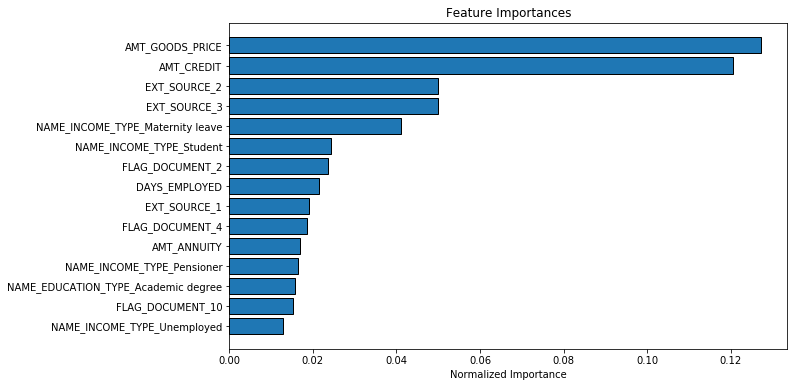

In [531]:
# 特徴量の重要性を抽出
features_names = list(train.columns)

feature_importance_values = abs(lr_scale.coef_.flatten())
feature_importances = pd.DataFrame({'feature': features_names, 'importance': feature_importance_values})

plot_feature_importances(feature_importances)

>AMT_CREDIT、AMT_GOODS_PRICE、EXT_SOURCE_2、EXT_SOURCE_3が重要であることが分かる。その他、カテゴリー変数ではNAME_INCOME_TYPEが上位に来ている。

>##### 2. ドメイン調査による特徴量作成
>借入額周りが重要な特徴量と分かったため、貸借審査で使用される指標値、DTI(debt to income ratio)を計算し、新たな特徴量としてデータに加える。

In [16]:
# 収入、ローン額、ローン対象購入物を調査
train[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE']].describe()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE
count,3.075110e+05,3.075110e+05,3.075110e+05
mean,1.687391e+05,5.988308e+05,5.378983e+05
std,2.371759e+05,4.024795e+05,3.694427e+05
min,2.565000e+04,4.500000e+04,4.050000e+04
25%,1.125000e+05,2.700000e+05,2.385000e+05
50%,1.471500e+05,5.135310e+05,4.500000e+05
75%,2.025000e+05,8.086500e+05,6.795000e+05
max,1.170000e+08,4.050000e+06,4.050000e+06


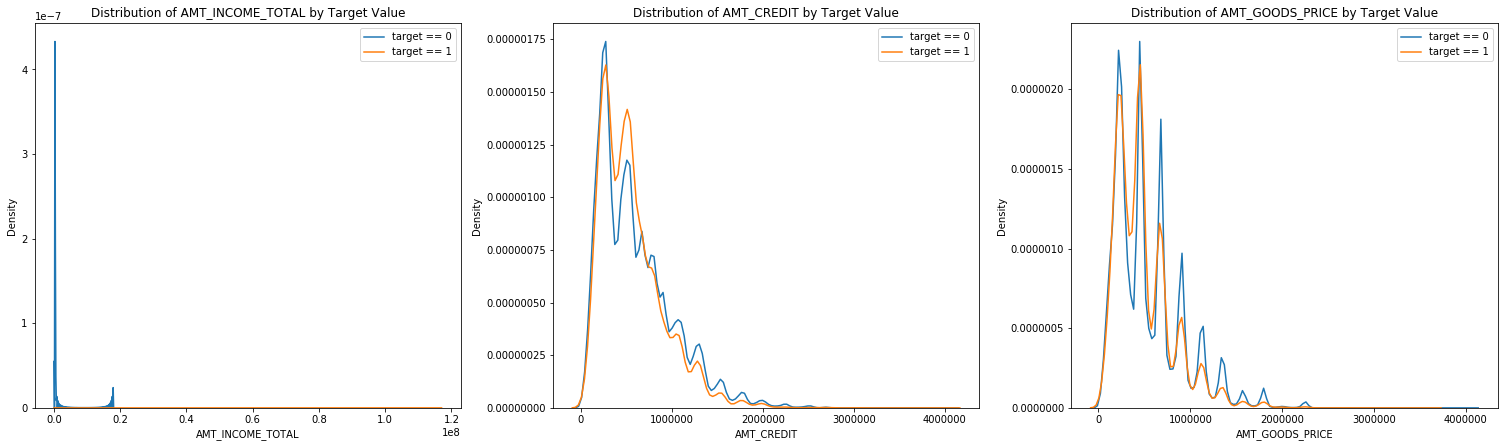

In [17]:
# 収入、ローン額、ローン対象購入物の分布を確認
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (21, 12))

# グラフ用にtrainとtargetを結合
plot_data = pd.concat([train, target], axis=1)

for i, source in enumerate(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE']):
    
    plt.subplot(2, 3, i + 1)
    sns.kdeplot(plot_data.loc[plot_data['TARGET'] == 0, source], label='target == 0')
    sns.kdeplot(plot_data.loc[plot_data['TARGET'] == 1, source], label='target == 1')
    
    plt.title('Distribution of {} by Target Value'.format(source))
    plt.xlabel('{}'.format(source)); plt.ylabel('Density');
    
plt.tight_layout(h_pad=2.5)

>いずれの特徴量も右の袖が大きく広がっていることが判る（＝歪度が正値）。また、AMT_GOODS_PRICEはピークが等間隔で現れているため、グループ化している可能性が高い。こちらは後ほどbinningで処理する。

In [537]:
# DTIを計算し、新たな特徴量として格納
train_DTI = train.copy()

train_DTI['DTI'] = train_DTI['AMT_CREDIT']/train_DTI['AMT_INCOME_TOTAL']

train_DTI['DTI'].describe()

count    307511.000000
mean          3.957726
std           2.689521
min           0.004808
25%           2.018667
50%           3.265067
75%           5.159880
max          84.736839
Name: DTI, dtype: float64

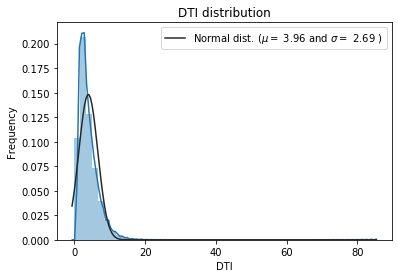

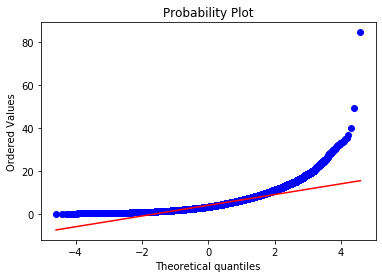

In [533]:
# DTIの分布を確認
from scipy import stats
from scipy.stats import norm
import numpy as np

sns.distplot(train_DTI['DTI'], fit=norm)

(mu, sigma) = norm.fit(train_DTI['DTI'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('DTI distribution')

fig = plt.figure()
res = stats.probplot(train_DTI['DTI'], plot=plt)
plt.show()

>DTIは正規分布だが、こちらも大きく右へ歪んでいることが分かる。歪度を正すため、Quantile Transformerによる標準化で処理を行う。

In [546]:
# DTIを追加したデータを学習＆推定
X = np.array(train_DTI)
y = np.array(target)

scaler = QuantileTransformer(output_distribution='normal')

lr_DTI = LogisticRegression(max_iter=1000)
score_DTI = model_score(lr_DTI, X, y, scaler=scaler)

print("DTI追加モデルのAUC ROC値：{:5f}".format(score_DTI))
print("-"*50)
print("ベースラインモデルのAUC ROC値：{:5f}".format(score_bl))
print("標準化処理モデルのAUC ROC値：{:5f}".format(score_scale))

DTI追加モデルのAUC ROC値：0.745974
--------------------------------------------------
ベースラインモデルのAUC ROC値：0.622992
標準化処理モデルのAUC ROC値：0.747225


>DTIの追加ではあまりスコアが変わらない。

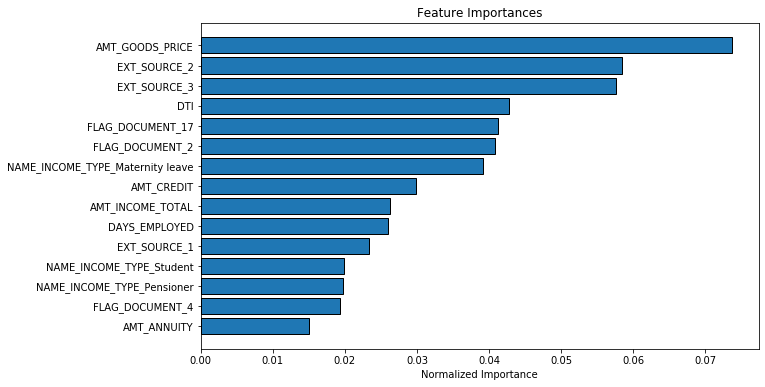

In [549]:
# 特徴量の重要性を抽出
features_names = list(train_DTI.columns)

feature_importance_values = abs(lr_DTI.coef_.flatten())
feature_importances = pd.DataFrame({'feature': features_names, 'importance': feature_importance_values})

plot_feature_importances(feature_importances)

>DTIのみの追加では推定結果にあまり影響が無かったが、上記表よりDTIの重要性が高い位置にあることが分かる。そのほかの特徴量と組み合わせる事を検討する余地はある。

>##### 3. AMT_GOODS_PRICEをグループ化
>AMT_GOODS_PRICEのbinningをpandas.cutで行う。境界値はヒストグラムの各ノードより求める。

In [541]:
# データをコピー
train_bin = train.copy()

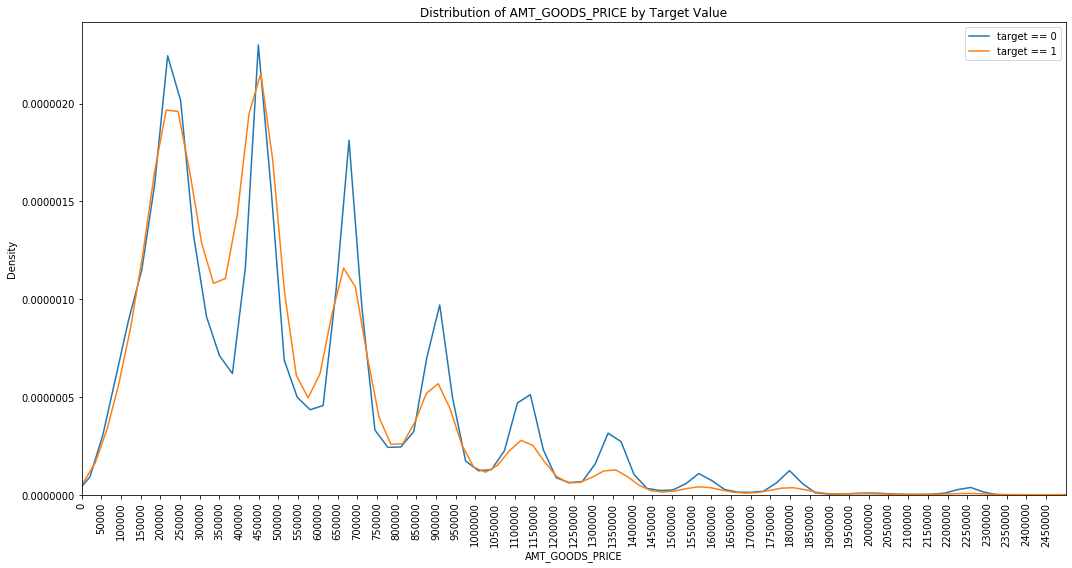

In [542]:
#binning用の境界値を確認

# グラフ用にtrainとtargetを結合
plot_data = pd.concat([train, target], axis=1)

plt.figure(figsize=(15,8))

for i, source in enumerate(['AMT_GOODS_PRICE']):
    
    plt.subplot()
    sns.kdeplot(plot_data.loc[plot_data['TARGET'] == 0, 'AMT_GOODS_PRICE'], label='target == 0')
    sns.kdeplot(plot_data.loc[plot_data['TARGET'] == 1, 'AMT_GOODS_PRICE'], label='target == 1')
    
    plt.title('Distribution of AMT_GOODS_PRICE by Target Value'.format(source))
    plt.xlabel('{}'.format(source)); plt.ylabel('Density');
    plt.xlim(0, 2500000)
    plt.xticks(np.arange(0, 2500000, 50000), rotation=90)
    
plt.tight_layout(h_pad=2.5)
plt.show()

In [543]:
#境界値のリスト
boundaries = [0,350000,575000,800000,1025000,1250000,1475000,1700000,1900000,4500000]

#各グループのサンプル数を確認
pd.cut(train_bin['AMT_GOODS_PRICE'], boundaries).value_counts()

(0, 350000]           116312
(350000, 575000]       75748
(575000, 800000]       52087
(800000, 1025000]      29881
(1025000, 1250000]     16913
(1250000, 1475000]      9492
(1475000, 1700000]      3065
(1700000, 1900000]      2725
(1900000, 4500000]      1288
Name: AMT_GOODS_PRICE, dtype: int64

In [544]:
# bin値をAMT_GOODS_PRICEに代入
train_bin['AMT_GOODS_PRICE'] = pd.cut(train_bin['AMT_GOODS_PRICE'], boundaries)

# bin値をobj型に変換
train_bin['AMT_GOODS_PRICE'] = train_bin['AMT_GOODS_PRICE'].astype(str)

# AMT_GOODS_PRICEのラベリングを行う
# 順序尺度のため、one-hotではなくlabel encodingを実装
le = LabelEncoder()

le.fit(train_bin['AMT_GOODS_PRICE'])

train_bin['AMT_GOODS_PRICE'] = le.transform(train_bin['AMT_GOODS_PRICE'])

train_bin['AMT_GOODS_PRICE'].head()

0    6
1    1
2    0
3    0
4    6
Name: AMT_GOODS_PRICE, dtype: int64

In [551]:
# Binningデータを追加し、学習＆推定
X = np.array(train_bin)
y = np.array(target)

lr_bin = LogisticRegression(max_iter=1000)

scaler = QuantileTransformer(output_distribution='normal')
score_bin = model_score(lr_bin, X, y, scaler=scaler)

print("Binning処理モデルのAUC ROC値：{:5f}".format(score_bin))
print("-"*50)
print("ベースラインモデルのAUC ROC値：{:5f}".format(score_bl))
print("標準化処理モデルのAUC ROC値：{:5f}".format(score_scale))
print("DTI追加モデルのAUC ROC値：{:5f}".format(score_DTI))

Binning処理モデルのAUC ROC値：0.744808
--------------------------------------------------
ベースラインモデルのAUC ROC値：0.622992
標準化処理モデルのAUC ROC値：0.747225
DTI追加モデルのAUC ROC値：0.745974


>AMT_GOODS_PRICEをBinning処理し、カテゴリー変数に変えたがスコアは標準化のみのモデルより下がってしまった。

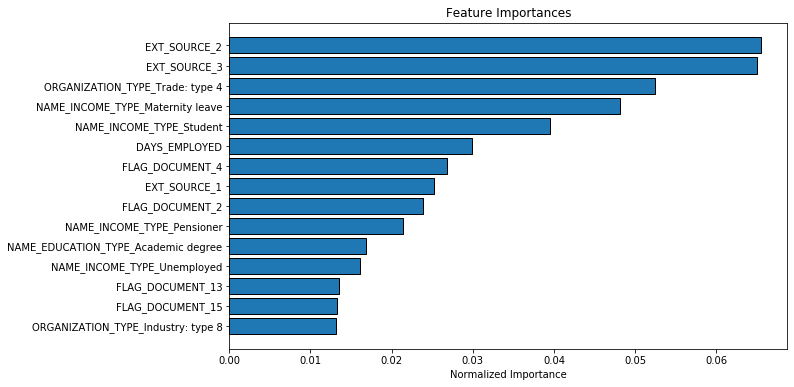

In [552]:
# 特徴量の重要性を抽出
features_names = list(train_bin.columns)

feature_importance_values = abs(lr_bin.coef_.flatten())
feature_importances = pd.DataFrame({'feature': features_names, 'importance': feature_importance_values})

plot_feature_importances(feature_importances)

>binning処理したAMT_GOODS_PRICEは重要性上位には無かった。カテゴリー変数化せずに量的データのまま活用するべきと考えられる。

>##### 4. Polynomial Features
>重要性の高いEXT_SOURCE_2とEXT_SOURCE_3に加え、顧客の借入額や収入に関する特徴量をを掛け合わせて新たな多次元特徴量を作成し、それらでモデルの学習を行う。

In [631]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(include_bias=False)

train_poly = poly.fit_transform(
    train.loc[:, ['AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_ANNUITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3']])

In [632]:
# 多次元特徴量を追加し、学習＆推定
X = np.array(train_poly)
y = np.array(target)

scaler = QuantileTransformer(output_distribution='normal')

lr_poly = LogisticRegression(max_iter=1000)
score_poly = model_score(lr_poly, X, y, scaler=scaler)

print("Polyfeatures生成モデルのAUC ROC値：{:5f}".format(score_poly))
print("-"*50)
print("ベースラインモデルのAUC ROC値：{:5f}".format(score_bl))
print("標準化処理モデルのAUC ROC値：{:5f}".format(score_scale))
print("DTI追加モデルのAUC ROC値：{:5f}".format(score_DTI))
print("Binning処理モデルのAUC ROC値：{:5f}".format(score_bin))

Polyfeatures生成モデルのAUC ROC値：0.718731
--------------------------------------------------
ベースラインモデルのAUC ROC値：0.622992
標準化処理モデルのAUC ROC値：0.747225
DTI追加モデルのAUC ROC値：0.745974
Binning処理モデルのAUC ROC値：0.744808


>多次元特徴量のみを使用した場合、全ての特徴量を使用するのと比べ、若干スコアが下がった。改めて多次元特徴量の重要性を下記にて確認。

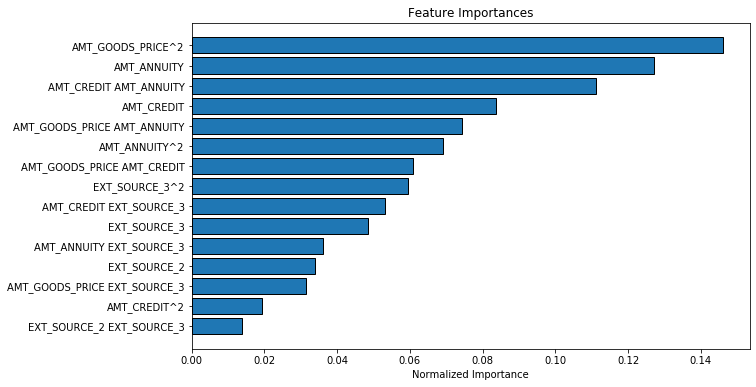

In [633]:
# 生成された特徴量の重要性を確認
features_names = poly.get_feature_names(input_features = ['AMT_GOODS_PRICE', 'AMT_CREDIT', 'AMT_ANNUITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])

feature_importance_values = abs(lr_poly.coef_.flatten())
feature_importances = pd.DataFrame({'feature': features_names, 'importance': feature_importance_values})

plot_feature_importances(feature_importances)

>特徴量同士を掛け合わせたものより、EXT_SOURCE_3やAMT_CREDITの多次元特徴量が重要のようである。最終モデルではこれら特徴量の使用を検討する。

>##### 5. Target Encoding
>カテゴリー変数と目的変数を掛け合わせて新たな特徴量を作成する。ここでは前項で重要と判明したNAME_INCOME_TYPEのEncodingを行う。ここではKFoldを用いたTarget Encodingを実装する。<br>
><br>
>ソースコードはリンク先を参照した。[Python: Target Encoding のやり方について](https://blog.amedama.jp/entry/target-mean-encoding-types#Holdout-TS)

In [556]:
# One-Hot Encoding実装前のデータを抽出
train_drop = all_data_drop[:ntrain]

# NAME_INCOME_TYPEとTARGETのみのDF作成
data_income = pd.concat((train_drop['NAME_INCOME_TYPE'], target), axis=1)

# NAME_INCOME_TYPEの種別毎の合計および頻値を格納
agg_df = data_income.groupby('NAME_INCOME_TYPE').agg({'TARGET': ['sum', 'count']})
agg_df

TARGET        
                          sum   count
NAME_INCOME_TYPE                     
Businessman               0.0      10
Commercial associate   5360.0   71617
Maternity leave           2.0       5
Pensioner              2982.0   55362
State servant          1249.0   21703
Student                   0.0      18
Unemployed                8.0      22
Working               15224.0  158774

In [557]:
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 生成した特徴量を格納するSeries
ts = pd.Series(np.empty(data_income.shape[0]), index=data_income.index)

In [558]:
for _, holdout_idx in folds.split(data_income, data_income.TARGET):
    # ホールドアウトする行を取り出す
    holdout_df = data_income.iloc[holdout_idx]
    # ホールドアウトしたデータで合計とカウントを計算する
    holdout_agg_df = holdout_df.groupby('NAME_INCOME_TYPE').agg({'TARGET': ['sum', 'count']})
    # 全体の集計からホールドアウトした分を引く
    train_agg_df = agg_df - holdout_agg_df
    # ホールドアウトしたデータの平均値を計算していく
    oof_ts = holdout_df.apply(lambda row: train_agg_df.loc[row.NAME_INCOME_TYPE][('TARGET', 'sum')]
                                          / train_agg_df.loc[row.NAME_INCOME_TYPE][('TARGET', 'count')], axis=1)
    # 生成した特徴量を記録する
    ts[oof_ts.index] = oof_ts

In [560]:
# 完成した特徴量をデータフレームに戻す
ts.name = 'INCOME_TYPE_ts'
train_ts = train.join(ts)

# 元になったNAME_INCOME_TYPEは削除
col_name_inc = train_ts.loc[:, train_ts.columns.str.contains('NAME_INCOME')]
train_ts.drop(columns=col_name_inc, inplace=True)

train_ts.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,...,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,INCOME_TYPE_ts
0,0,202500.0,406597.5,24700.5,351000.0,0.018799,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,

In [634]:
# Target Encodingデータを追加し、学習＆推定
X = np.array(train_ts)
y = np.array(target)

scaler = QuantileTransformer(output_distribution='normal')

lr_ts = LogisticRegression(max_iter=1000)
score_ts = model_score(lr_ts, X, y, scaler=scaler)

print("TargetEncoding生成モデルのAUC ROC値：{:5f}".format(score_ts))
print("-"*50)
print("ベースラインモデルのAUC ROC値：{:5f}".format(score_bl))
print("標準化処理モデルのAUC ROC値：{:5f}".format(score_scale))
print("DTI追加モデルのAUC ROC値：{:5f}".format(score_DTI))
print("Binning処理モデルのAUC ROC値：{:5f}".format(score_bin))
print("Polyfeatures生成モデルのAUC ROC値：{:5f}".format(score_poly))

TargetEncoding生成モデルのAUC ROC値：0.741132
--------------------------------------------------
ベースラインモデルのAUC ROC値：0.622992
標準化処理モデルのAUC ROC値：0.747225
DTI追加モデルのAUC ROC値：0.745974
Binning処理モデルのAUC ROC値：0.744808
Polyfeatures生成モデルのAUC ROC値：0.718731


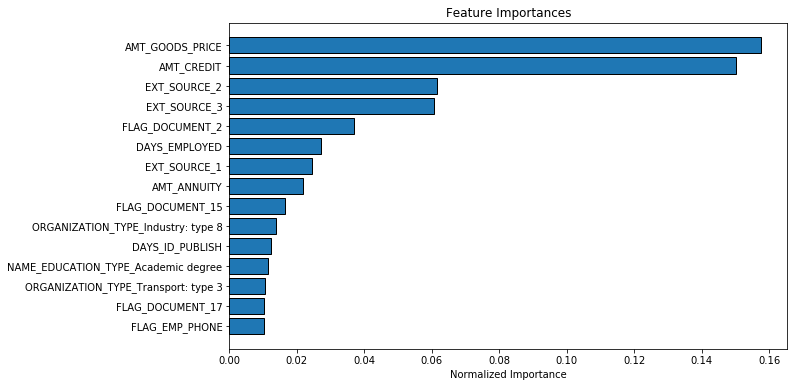

In [562]:
# 特徴量の重要性を抽出
features_names = list(train_ts.columns)

feature_importance_values = abs(lr_ts.coef_.flatten())
feature_importances = pd.DataFrame({'feature': features_names, 'importance': feature_importance_values})

plot_feature_importances(feature_importances)

>Target Encodingデータの追加はDTI追加データと同程度の推定結果となった。特徴量の重要性についても、One-hot Encodingより低いと思われる。

>最も精度の高かった特徴量や処理一覧：
>- 10%以上の欠損値を含む特徴量を除外
>- 10%未満の欠損値は中央値（数値データ）または最頻値（カテゴリーデータ）で補完
>- カテゴリー変数はone-hot labeling
>- DTIを計算し、元となるAMT_CREDIT、AMT_INCOME_TOTALを削除
>- 多次元特徴量の追加
>- データは全てQuantile Transformationで標準化および正規化を実装<br>
><br>
>
>上記の処理を行い、最終モデルを作成する。

In [639]:
# trainとtestデータを一度に加工
all_data_submit = all_data_lab.copy()

# DTIを追加
all_data_submit['DTI'] = all_data_submit['AMT_CREDIT']/all_data_submit['AMT_INCOME_TOTAL']
# DTI計算の元となった特徴量を削除
all_data_submit.drop(columns=['AMT_CREDIT', 'AMT_INCOME_TOTAL'], inplace=True)

# 多次元特徴量の生成
poly = PolynomialFeatures(include_bias=False)

all_data_poly = poly.fit_transform(
    all_data_submit.loc[:, ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DTI', 'EXT_SOURCE_2', 'EXT_SOURCE_3']])
feature_names = poly.get_feature_names(
    input_features = ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DTI', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])

# # 多次元特徴量生成の元となった特徴量を削除（重複するため）
all_data_submit.drop(columns=['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DTI', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], inplace=True)

# # 元のデータフレームと多次元特徴量を結合
all_data_submit = pd.concat((all_data_submit,
                             pd.DataFrame(data=all_data_poly, columns=feature_names)),
                             axis=1)

# trainとtestに分割
train_submit = all_data_submit[:ntrain]
test_submit = all_data_submit[ntrain:]

In [642]:
# 最終モデルの学習＆推定
X = np.array(train_submit)
y = np.array(target)

scaler = QuantileTransformer(output_distribution='normal')

lr_submit = LogisticRegression(max_iter=10000)
score_submit = model_score(lr_submit, X, y, scaler=scaler)

print("最終モデルのAUC ROC値：{:5f}".format(score_submit))
print("-"*50)
print("ベースラインモデルのAUC ROC値：{:5f}".format(score_bl))
print("標準化処理モデルのAUC ROC値：{:5f}".format(score_scale))
print("DTI追加モデルのAUC ROC値：{:5f}".format(score_DTI))
print("Binning処理モデルのAUC ROC値：{:5f}".format(score_bin))
print("Polyfeatures生成モデルのAUC ROC値：{:5f}".format(score_poly))
print("TargetEncoding生成モデルのAUC ROC値：{:5f}".format(score_ts))

最終モデルのAUC ROC値：0.747544
--------------------------------------------------
ベースラインモデルのAUC ROC値：0.622992
標準化処理モデルのAUC ROC値：0.747225
DTI追加モデルのAUC ROC値：0.745974
Binning処理モデルのAUC ROC値：0.744808
Polyfeatures生成モデルのAUC ROC値：0.718731
TargetEncoding生成モデルのAUC ROC値：0.741132


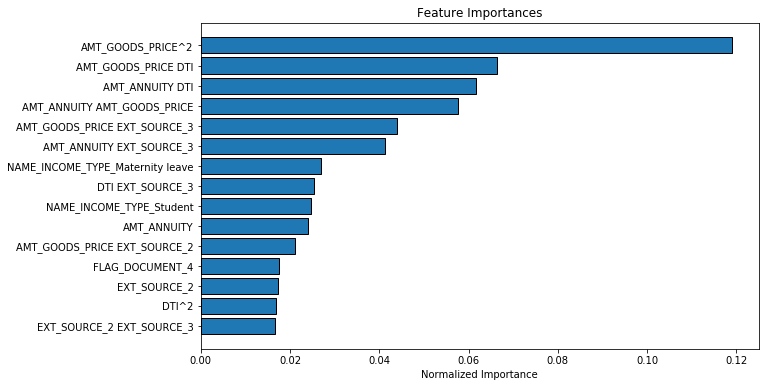

In [640]:
# 特徴量の重要性を抽出
feature_names = train_submit.columns

feature_importance_values = abs(lr_submit.coef_.flatten())
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

plot_feature_importances(feature_importances)

>ここまで検証した手法を組み合わせたモデルが最も精度が高い結果となった（たまたまの可能性もあるが…）。また、特徴量の重要性も今回生成した特徴量が上位を占める。この最終モデルで全ての訓練データに対して学習を行い、テストデータを推定し、Kaggleに提出する。

In [648]:
# Submission用DF作成
# 全train dataを学習させる
X_train = np.array(train_submit)
X_test = np.array(test_submit)
y = np.array(target)

lr_full = LogisticRegression(max_iter=10000)
scaler = QuantileTransformer(output_distribution='normal')

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr_full.fit(X_train, target)
pred_submit = lr_full.predict_proba(X_test)
output = pd.DataFrame({'SK_ID_CURR': sk_id,
                       'TARGET': pred_submit[:,1]})

output

,SK_ID_CURR,TARGET
0,100001,0.044691
1,100005,0.174960
2,100013,0.049961
3,100028,0.040776
4,100038,0.140718
...,...,...
48739,456221,0.030477
48740,456222,0.044954
48741,456223,0.054270
48742,456224,0.080762


In [649]:
# csvに書き込み
output.to_csv('submission1.csv', index=False)

>Kaggle上のスコアは**0.74174**。